## PART I. Index Construction

### 选择市场上交易量最大的50个币，通过交易量赋予权重，构建一个衡量整体市场波动率的指数VCRIX。

#### 主要参考文章：https://www.econstor.eu/bitstream/10419/230803/1/irtg1792dp2019-027.pdf

### 1.1 导入binance数据

In [2]:
import os
import pandas as pd
import numpy as np
from _datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [5]:
# read csv

binance = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/top50_hr.csv', sep=',')
binance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443877 entries, 0 to 443876
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time            443877 non-null  object 
 1   open            443877 non-null  float64
 2   high            443877 non-null  float64
 3   low             443877 non-null  float64
 4   close           443877 non-null  float64
 5   volume          443877 non-null  float64
 6   adjusted_close  443877 non-null  float64
 7   tic             443877 non-null  object 
dtypes: float64(6), object(2)
memory usage: 27.1+ MB


In [6]:
binance

,time,open,high,low,close,volume,adjusted_close,tic
0,2022-01-01 00:00:00,3784.6400,3788.4500,3739.5700,3745.4900,1.139940e+04,3745.4900,ETHUSDT
1,2022-01-01 01:00:00,3745.4900,3754.2600,3705.0000,3722.0300,1.268786e+04,3722.0300,ETHUSDT
2,2022-01-01 02:00:00,3722.0400,3725.0100,3695.1600,3704.4300,1.046224e+04,3704.4300,ETHUSDT
3,2022-01-01 03:00:00,3704.4300,3705.9300,3623.0000,3626.2700,2.005540e+04,3626.2700,ETHUSDT
4,2022-01-01 04:00:00,3626.2100,3663.8700,3622.2900,3645.0400,1.228997e+04,3645.0400,ETHUSDT
...,...,...,...,...,...,...,...,...
443872,2023-01-29 19:00:00,0.0947,0.0955,0.0941,0.0955,5.574715e+06,0.0955,GRTUSDT
443873,2023-01-29 20:00:00,0.0954,0.0957,0.0947,0.0956,2.266958e+06,0.0956,GRTUSDT
443874,2023-01-29 21:00:00,0.0956,0.0963,0.0949,0.0951,5.360265e+06,0.0951,GRTUSDT
443875,2023-01-29 22:00:00,0.0951,0.0964,0.0950,0.0960,3.503151e+06,0.0960,GRTUSDT


### 1.2 计算权重weights
#### 参考 https://cci30.com/wp-content/uploads/2021/11/CCi30-Cryptocurrency-Index-Methodology-Manual.pdf 

In [7]:
# 用trading volume算出各个币的权重得到一个weights by月份
binance['month'] = binance['time'].str[:7]
binance['trading_volume'] = binance['volume'] * binance['adjusted_close']


In [8]:
# calculate the square root of monthly volume
volume_month = binance.groupby(['tic', 'month']).agg({'trading_volume': ['sum']}).reset_index().rename(columns={'trading_volume': 'volume_coin_month'})
volume_month.columns = [col[0] if col[1]=='' else col[0] for col in volume_month.columns]
volume_month['sqrt_vol_coin'] = np.sqrt(volume_month['volume_coin_month'])

In [9]:
# sum the sqrt of volume by month
volume_month_tot = volume_month.groupby(['month']).agg({'sqrt_vol_coin': ['sum']}).reset_index().rename(columns={'sqrt_vol_coin': 'sqrt_vol_tot'})

volume_month_tot.columns = [col[0] if col[1]=='' else col[0] for col in volume_month_tot.columns]

In [10]:
# calculate the weights
weights = pd.merge(volume_month, volume_month_tot, on='month', how='left')
weights['weight'] = weights['sqrt_vol_coin']/weights['sqrt_vol_tot']
weights

,tic,month,volume_coin_month,sqrt_vol_coin,sqrt_vol_tot,weight
0,AAVEUSDT,2022-01,1.045778e+09,32338.490091,2.640338e+06,0.012248
1,AAVEUSDT,2022-02,4.758526e+08,21814.045180,2.318286e+06,0.009410
2,AAVEUSDT,2022-03,1.102555e+09,33204.746853,2.591081e+06,0.012815
3,AAVEUSDT,2022-04,1.256343e+09,35444.935746,2.371911e+06,0.014944
4,AAVEUSDT,2022-05,1.001898e+09,31652.779544,2.487923e+06,0.012723
...,...,...,...,...,...,...
608,ZILUSDT,2022-09,2.071048e+08,14391.136405,1.857745e+06,0.007747
609,ZILUSDT,2022-10,2.066986e+08,14377.015186,1.593776e+06,0.009021
610,ZILUSDT,2022-11,2.241588e+08,14971.932292,1.867093e+06,0.008019
611,ZILUSDT,2022-12,6.478540e+07,8048.937896,1.320534e+06,0.006095


In [11]:
# check if makes sense
weights.groupby(['tic']).agg({'weight': ['mean']})


,weight
,mean
tic,
AAVEUSDT,0.011816
ADAUSDT,0.026507
APEUSDT,0.025641
APTUSDT,0.026326
ATOMUSDT,0.020374
AVAXUSDT,0.024777
AXSUSDT,0.014533
BCHUSDT,0.010422


In [24]:
# 把weights merge回by hour原数据
weights_hr = pd.merge(binance,weights, on=['tic','month'],how='outer', indicator = False)


In [48]:
weights_wide = weights_hr[['time','tic','weight']].pivot(index='time', columns='tic', values='weight').fillna(0)
weights_wide.rename(columns={col: col[:-4] for col in weights_wide.columns}, inplace=True)
weights_wide

tic,AAVE,ADA,APE,APT,ATOM,AVAX,AXS,BCH,BNB,BTC,...,SOL,TRX,TWT,UNI,VET,XLM,XMR,XRP,ZEC,ZIL
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.012248,0.034299,0.000000,0.000000,0.034363,0.026791,0.015943,0.010701,0.042776,0.085841,...,0.034351,0.022840,0.003607,0.011426,0.015241,0.010411,0.009688,0.029219,0.011689,0.007037
2022-01-01 01:00:00,0.012248,0.034299,0.000000,0.000000,0.034363,0.026791,0.015943,0.010701,0.042776,0.085841,...,0.034351,0.022840,0.003607,0.011426,0.015241,0.010411,0.009688,0.029219,0.011689,0.007037
2022-01-01 02:00:00,0.012248,0.034299,0.000000,0.000000,0.034363,0.026791,0.015943,0.010701,0.042776,0.085841,...,0.034351,0.022840,0.003607,0.011426,0.015241,0.010411,0.009688,0.029219,0.011689,0.007037
2022-01-01 03:00:00,0.012248,0.034299,0.000000,0.000000,0.034363,0.026791,0.015943,0.010701,0.042776,0.085841,...,0.034351,0.022840,0.003607,0.011426,0.015241,0.010411,0.009688,0.029219,0.011689,0.007037
2022-01-01 04:00:00,0.012248,0.034299,0.000000,0.000000,0.034363,0.026791,0.015943,0.010701,0.042776,0.085841,...,0.034351,0.022840,0.003607,0.011426,0.015241,0.010411,0.009688,0.029219,0.011689,0.007037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-29 19:00:00,0.010911,0.020825,0.017056,0.035765,0.015003,0.022086,0.015852,0.008435,0.028719,0.210621,...,0.037934,0.015318,0.009890,0.009828,0.007270,0.006414,0.011252,0.035063,0.006318,0.010876
2023-01-29 20:00:00,0.010911,0.020825,0.017056,0.035765,0.015003,0.022086,0.015852,0.008435,0.028719,0.210621,...,0.037934,0.015318,0.009890,0.009828,0.007270,0.006414,0.011252,0.035063,0.006318,0.010876
2023-01-29 21:00:00,0.010911,0.020825,0.017056,0.035765,0.015003,0.022086,0.015852,0.008435,0.028719,0.210621,...,0.037934,0.015318,0.009890,0.009828,0.007270,0.006414,0.011252,0.035063,0.006318,0.010876


### 1.3 计算return及volatility

In [35]:
# 导入价格计算return
returns = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/coins_price_hr.csv', sep=',', index_col= 'time')



In [37]:
# log return
def calc_log_returns(df, suffix='_r'):
    columns = [col for col in df.columns]
    log_returns = np.log(df[columns] / df[columns].shift(1))
    new_columns = [col + suffix for col in log_returns.columns]
    log_returns.columns = new_columns
    return log_returns

In [45]:
log_returns = calc_log_returns(returns)

In [60]:
# ewma计算方差
variance = log_returns.ewm(span=10).std() ** 2
variance.rename(columns={col: col[:-6] for col in variance.columns}, inplace=True)
variance.fillna(0, inplace=True)
variance

,AAVE,ADA,APE,APT,ATOM,AVAX,AXS,BCH,BNB,BTC,...,SOL,TRX,TWT,UNI,VET,XLM,XMR,XRP,ZEC,ZIL
time,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2022-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
2022-01-01 02:00:00,0.000028,0.000002,0.000000,0.000000,0.000046,0.000003,0.000107,0.000043,7.712087e-08,0.000003,...,7.871697e-07,0.000006,0.000174,0.000282,0.000006,0.000004,0.000259,0.000001,0.000017,2.745149e-07
2022-01-01 03:00:00,0.000109,0.000144,0.000000,0.000000,0.000977,0.001153,0.000072,0.000234,5.914080e-05,0.000059,...,7.787316e-05,0.000084,0.000231,0.000586,0.000085,0.000077,0.000282,0.000098,0.000059,2.709871e-04
2022-01-01 04:00:00,0.000185,0.000177,0.000000,0.000000,0.000745,0.001576,0.000167,0.000167,5.572329e-05,0.000117,...,1.062127e-04,0.000117,0.000171,0.000378,0.000131,0.000103,0.000207,0.000276,0.000047,3.069009e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-29 19:00:00,0.000022,0.000019,0.000046,0.000036,0.000023,0.000042,0.000060,0.000037,2.212400e-05,0.000011,...,2.383262e-05,0.000008,0.000109,0.000035,0.000019,0.000007,0.000030,0.000006,0.000046,4.248745e-05
2023-01-29 20:00:00,0.000029,0.000020,0.000041,0.000037,0.000020,0.000035,0.000078,0.000031,2.649778e-05,0.000009,...,2.337738e-05,0.000006,0.000089,0.000028,0.000016,0.000007,0.000025,0.000006,0.000041,3.477478e-05
2023-01-29 21:00:00,0.000025,0.000018,0.000034,0.000045,0.000016,0.000037,0.000064,0.000026,2.795023e-05,0.000008,...,1.990938e-05,0.000005,0.000085,0.000024,0.000020,0.000006,0.000021,0.000005,0.000045,3.104772e-05


In [61]:
# 将weights矩阵与variance matrix相乘再开方得到volatility
volatility = pd.DataFrame(np.sqrt(np.diag((np.dot(variance,np.transpose(weights_wide))))))
volatility.columns = ['volatility']
# 乘以10000得到VCRIX指数
volatility['VCRIX'] = volatility['volatility'] *10000

In [63]:
# set time index
date_range = pd.date_range(start='2022-01-01 00:00:00', end='2023-01-29 23:00:00', freq='H')
volatility = volatility.set_index(date_range)
volatility

,volatility,VCRIX
2022-01-01 00:00:00,0.000000,0.000000
2022-01-01 01:00:00,0.000000,0.000000
2022-01-01 02:00:00,0.005505,55.049891
2022-01-01 03:00:00,0.014411,144.113454
2022-01-01 04:00:00,0.016150,161.504328
...,...,...
2023-01-29 19:00:00,0.006783,67.834414
2023-01-29 20:00:00,0.006567,65.668486
2023-01-29 21:00:00,0.006506,65.059393
2023-01-29 22:00:00,0.006524,65.236160


## PART II. Visualization

In [57]:
# Plot settings

SCALE_FACTOR = 2

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [5 * SCALE_FACTOR, 2 * SCALE_FACTOR]
plt.rcParams['figure.dpi'] = 300 * SCALE_FACTOR
plt.rcParams['font.size'] = 5 * SCALE_FACTOR
plt.rcParams['axes.labelsize'] = 5 * SCALE_FACTOR
plt.rcParams['axes.titlesize'] = 6 * SCALE_FACTOR
plt.rcParams['xtick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['ytick.labelsize'] = 4 * SCALE_FACTOR
plt.rcParams['font.family'] = 'serif'

/var/folders/lx/f8gcbnbd18x_k936zw7ddqrh0000gn/T/ipykernel_40071/3729068229.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [66]:
# btc eth
btc = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/btc_hr.csv', sep=',')
eth = pd.read_csv('/Users/wanjinwoo/Desktop/Antalpha/Github/data/eth_hr.csv', sep=',')
# convert dates to timestamp and make dates index
eth['time'] = pd.to_datetime(eth['time'])
eth.index=pd.to_datetime(eth.time)
eth.drop('time', inplace=True, axis=1)

btc['time'] = pd.to_datetime(btc['time'])
btc.index=pd.to_datetime(btc.time)
btc.drop('time', inplace=True, axis=1)

In [67]:
# log
btc_log = pd.DataFrame(np.log(btc['adjusted_close']))
eth_log = pd.DataFrame(np.log(eth['adjusted_close']))
volatility['vcrix_log'] = np.log(volatility['VCRIX'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [188]:
vola_2122 = volatility[(volatility.index >= datetime(2021, 1, 1)) ]
btc_log1 =btc_log[(btc_log.index >= datetime(2021, 1, 1))]
eth_log1 =eth_log[(eth_log.index >= datetime(2021, 1, 1))]

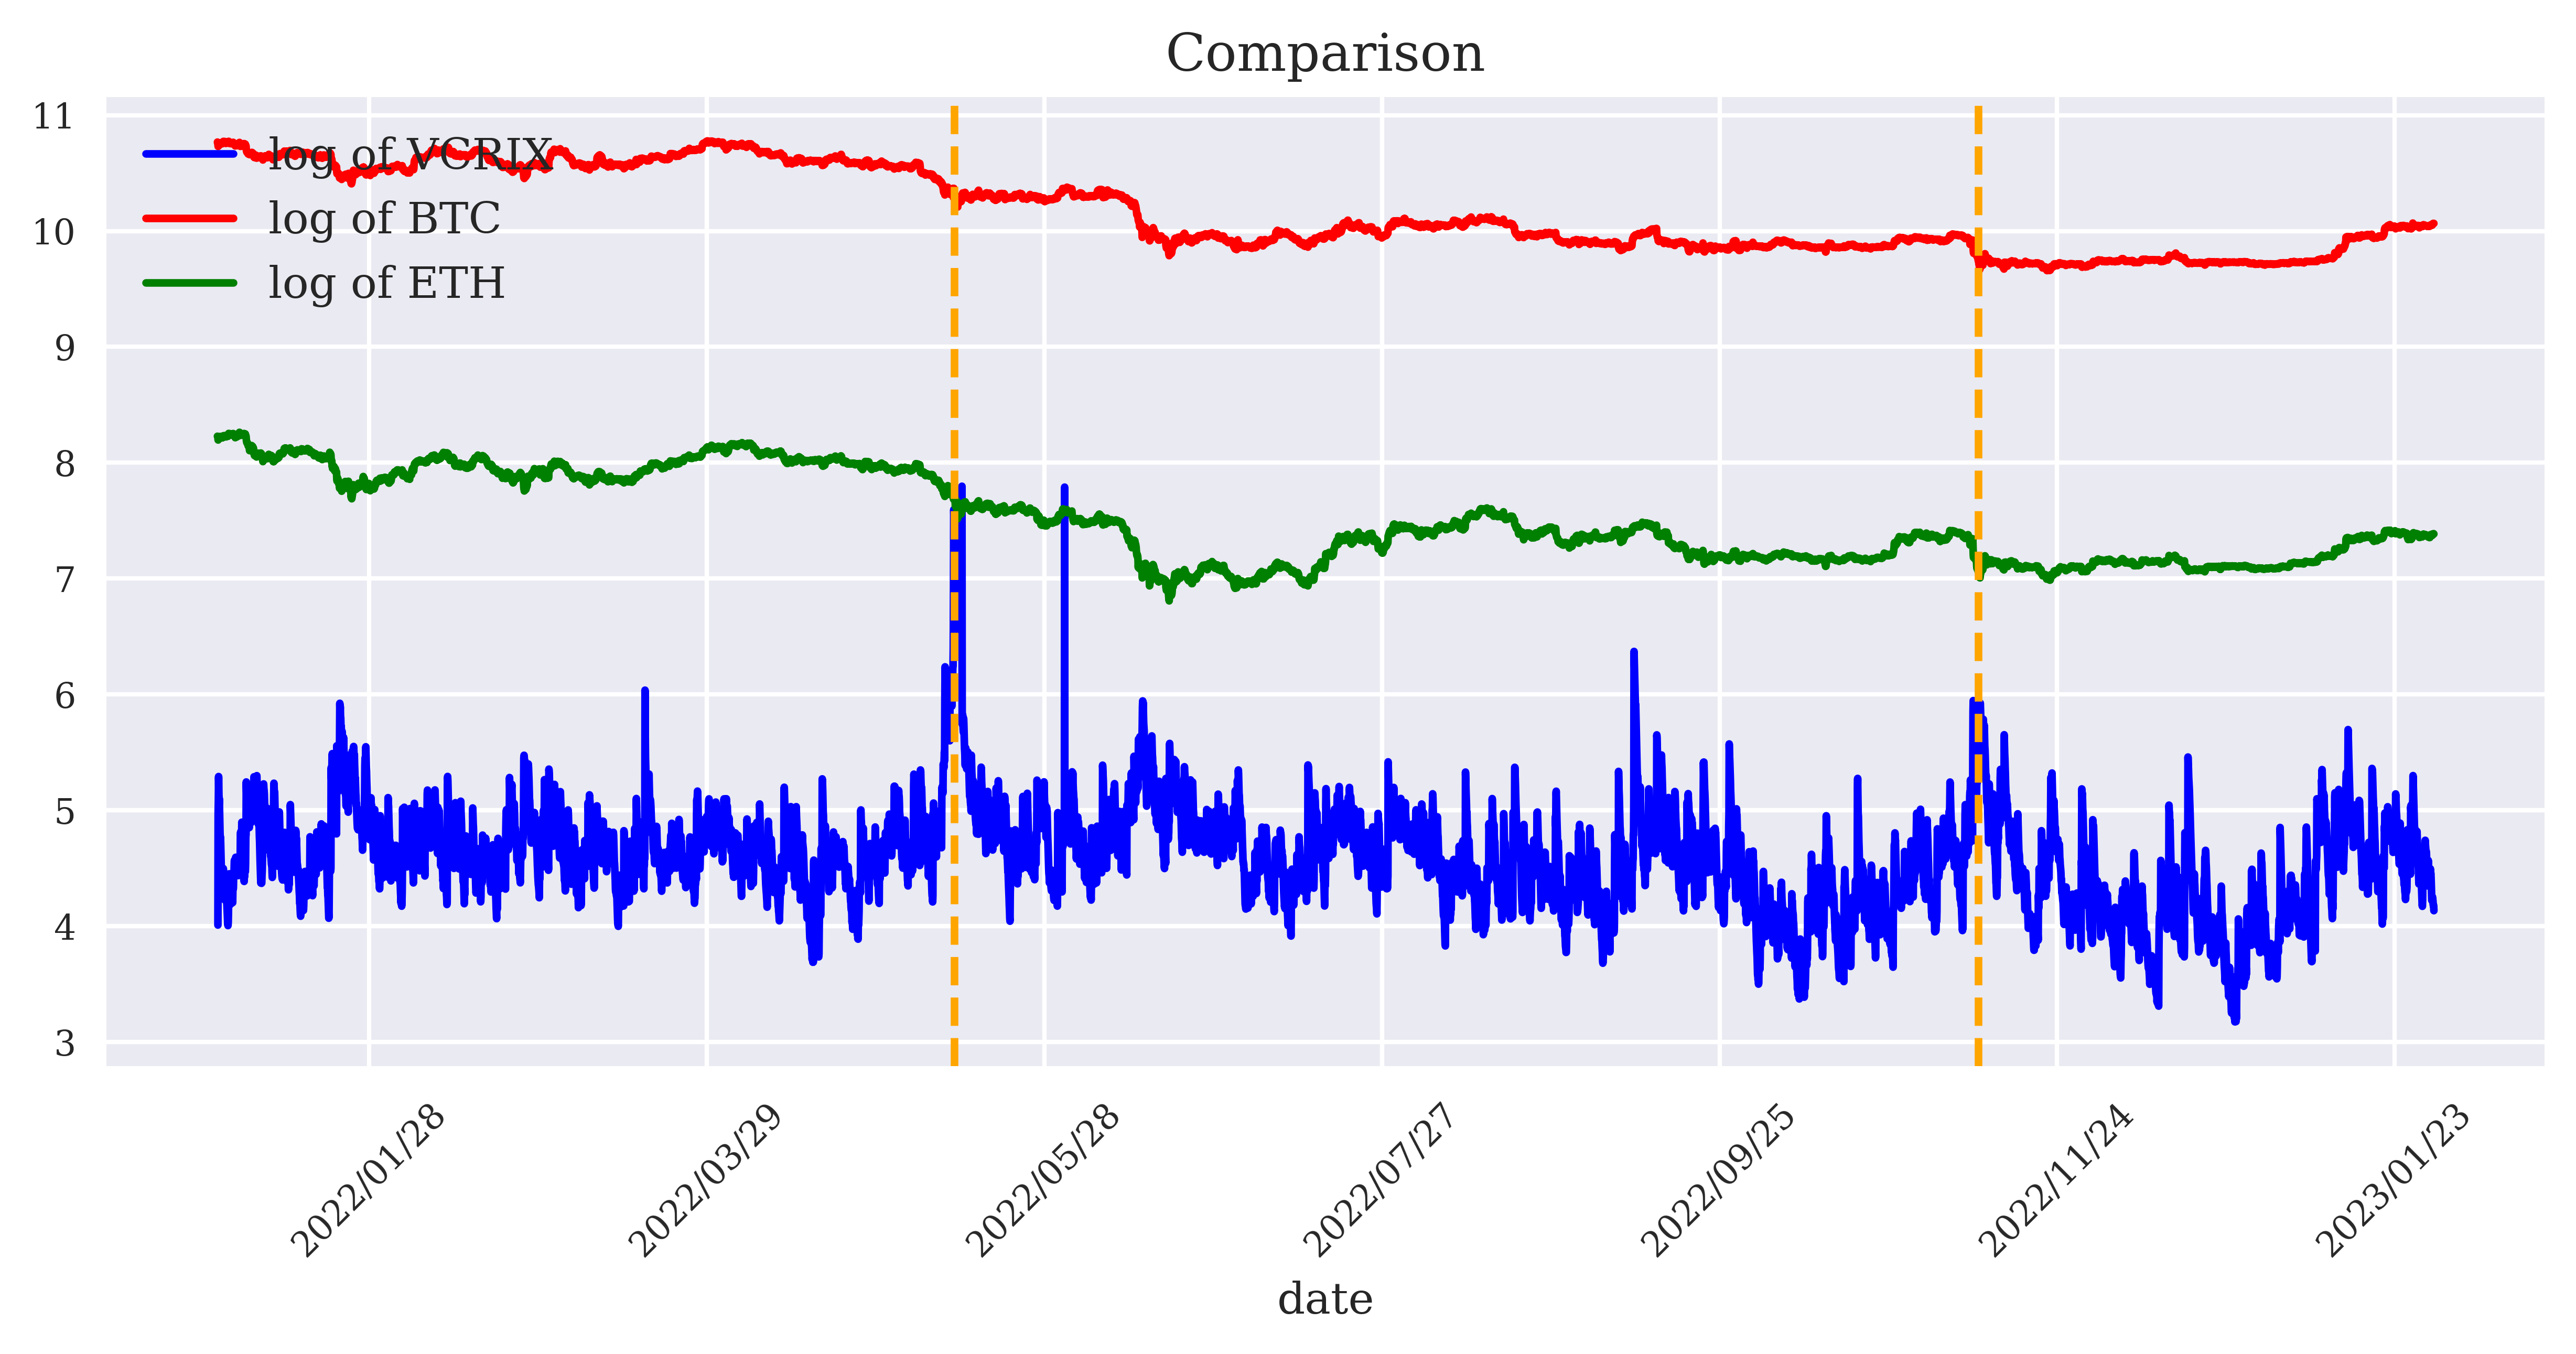

In [69]:
fig,ax = plt.subplots()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))

ax.set(title='Comparison',
       xlabel='date')
ax.plot(volatility.vcrix_log,c='b',label='log of VCRIX')
ax.plot(btc_log.adjusted_close,c='r',label='log of BTC')
ax.plot(eth_log.adjusted_close,c='g',label='log of ETH') 
# ax.axvline(x=datetime(2021, 5, 19), color='orange', linestyle = 'dashed')
ax.axvline(x=datetime(2022, 5, 12), color='orange', linestyle = 'dashed')
ax.axvline(x=datetime(2022, 11, 10), color='orange', linestyle = 'dashed')
plt.legend(loc=2)

## PART III. How to use VCRIX to alert abnormal volatility?

### 1. Time series (HAR) model to forecast volatility
https://github.com/deep-hedger-Peng/HAR-RV/blob/master/HAR-RV_forecast.ipynb

In [71]:
# 用历史数据预测未来volatility

### 2. 根据ETH/BTC/指数本身的历史波动范围确定阈值，当预测的VCRIX达到阈值便预警

In [ ]:
# (1)计算ETH/BTC历史每小时价格浮动范围
range = (Pmax - Pmin )/ Pmin 

# (2) 找出90th percentile作为threshold
threshold = p90(range)

# (3) 当VCRIX波动达到threshold，预警
